In [1]:
# Імпорт бібліотек
import pandas as pd
import numpy as np
import tensorflow as tf
import logging
import matplotlib.pyplot as plt

tf.get_logger().setLevel(logging.ERROR)
from load_dataset import (
    classes,
    x_train,
    y_train,
    x_test,
    y_test,
)

In [2]:
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [3]:
# Представлення назв класів у вигляді словника

class_names = {

    0: classes[0],

    1: classes[1],

    2: classes[2],

    3: classes[3],

    4: classes[4],

    5: classes[5],

    6: classes[6],

    7: classes[7],

    8: classes[8],

    9: classes[9],

}

In [4]:
def preprocess_image_input(input_images):
    """
    Виконує попередню обробку вхідних зображень для подальшого використання в моделі ResNet50.

    Аргументи:
    input_images (numpy.array): Вхідні зображення у вигляді масиву.

    Повертає:
    numpy.array: Оброблені зображення.
    """




    input_images = input_images.astype("float32")





    output_ims = tf.keras.applications.resnet50.preprocess_input(input_images)


    return output_ims



def feature_extractor(inputs):
    """
    Створює екстрактор ознак на базі моделі ResNet50 без верхніх шарів.

    Аргументи:
    inputs (tf.Tensor): Вхідний тензор для екстрактора ознак.

    Повертає:
    tf.Tensor: Тензор з витягнутими ознаками.
    """



    feature_extractor = tf.keras.applications.resnet.ResNet50(





        input_shape=(224, 224, 3), include_top=False, weights="imagenet"
    )(inputs)





    return feature_extractor



def classifier(inputs):
    """
    Створює класифікатор на основі витягнутих ознак.

    Аргументи:
    inputs (tf.Tensor): Вхідний тензор з витягнутими ознаками.

    Повертає:
    tf.Tensor: Тензор з класифікаційними виходами.
    """


    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)


    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)

    return x



def final_model(inputs):


    """
    Створює фінальну модель, що включає попередню обробку, екстракцію ознак та класифікацію.

    Аргументи:
    inputs (tf.Tensor): Вхідний тензор для моделі.

    Повертає:
    tf.Tensor: Тензор з класифікаційними виходами.
    """

    resize = tf.keras.layers.UpSampling2D(size=(7, 7))(inputs)

    resnet_feature_extractor = feature_extractor(resize)

    classification_output = classifier(resnet_feature_extractor)

    return classification_output



def define_compile_model():
    """
    Визначає та компілює кінцеву модель.

    Повертає:
    tf.keras.Model: Скомпільована модель.
    """

    inputs = tf.keras.layers.Input(shape=(32, 32, 3))

    classification_output = final_model(inputs)

    model = tf.keras.Model(inputs=inputs, outputs=classification_output)

    model.compile(

        optimizer="SGD", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )

    return model

In [5]:
# Трансформуємо вхідні дані
train_X = preprocess_image_input(x_train)
valid_X = preprocess_image_input(x_test)

In [7]:
# Визначаємо модель
model = define_compile_model()

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ classification (Dense)               │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,215,818 (100.01 MB)

 Trainable params: 26,162,698 (99.80 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [8]:
# Тренуємо модель
history = model.fit(
    train_X,
    y_train,
    epochs=5,
    validation_split=0.2,
    batch_size=64,
)

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 395s 556ms/step - accuracy: 0.7377 - loss: 0.8158 - val_accuracy: 0.9198 - val_loss: 0.2349
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 353s 565ms/step - accuracy: 0.9647 - loss: 0.1127 - val_accuracy: 0.9384 - val_loss: 0.1791
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 379s 561ms/step - accuracy: 0.9902 - loss: 0.0392 - val_accuracy: 0.9470 - val_loss: 0.1648
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 335s 536ms/step - accuracy: 0.9969 - loss: 0.0159 - val_accuracy: 0.9521 - val_loss: 0.1613
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 397s 561ms/step - accuracy: 0.9982 - loss: 0.0085 - val_accuracy: 0.9543 - val_loss: 0.1699


In [9]:
# Зберігаємо модель
model.save("resnet_best.keras")

In [10]:
# Перевіряємо на тестових даних
loss, accuracy = model.evaluate(valid_X, y_test, batch_size=64)

157/157 ━━━━━━━━━━━━━━━━━━━━ 23s 143ms/step - accuracy: 0.9457 - loss: 0.1854


In [11]:
# Завантажуємо модель
model = tf.keras.models.load_model("models/resnet_best.h5")
model.summary()

KeyboardInterrupt: 

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import os

print(os.getcwd())
from load_dataset import (
    x_test,
    y_test,
    x_train,
    y_train,
    classes,
)


def visualize_predictions(model, n=15, rows=3):
    """
    Візуалізує передбачення моделі на тестовому наборі даних.

    Аргументи:
    model (tf.keras.Model): Модель, яка буде використовуватись для передбачення.
    n (int): Кількість зображень для візуалізації. За замовчуванням 15.
    rows (int): Кількість рядів у графіку. За замовчуванням 3.

    Повертає:
    None: Функція нічого не повертає, вона лише візуалізує результати.
    """
    start = np.random.randint(0, len(x_test) - n)
    end = start + n
    to_predict = x_test[start:end]
    predicted = model.predict(to_predict)
    real = y_test[start:end]

    cols = (n + rows - 1) // rows

    print(f" Labels:      {real.T[0]}")
    print(f" Predictions: {np.argmax(predicted, axis=1)}")

    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))

    for i in range(n):
        row = i // cols
        col = i % cols
        axes[row, col].imshow(to_predict[i])
        axes[row, col].set_title(
            f"predicted: {classes[np.argmax(predicted[i])]}\nreal label: {classes[real[i][0]]}"
        )
        axes[row, col].axis("off")

    for i in range(n, rows * cols):
        fig.delaxes(axes.flatten()[i])

    plt.tight_layout()
    plt.show()


def history_plot(history):
    """
    Візуалізує історію тренувань моделі, показуючи точність та втрати.

    Аргументи:
    history (tf.keras.callbacks.History): Історія тренувань моделі.

    Повертає:
    None: Функція нічого не повертає, вона лише візуалізує результати.
    """
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.legend(["accuracy", "val_accuracy"])
    plt.grid()
    plt.title("Accuracy")
    plt.show()
    plt.legend(["loss", "val_loss"])
    plt.title("Loss")
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.grid()
    plt.show()


def calculate_percent_right_mob(test, labels, model):
    """
    Обчислює відсоток правильних класифікацій для кожного класу на тестовому наборі даних
    та візуалізує результати у вигляді гістограми для мобільної мережі.

    Аргументи:
    test (numpy.array): Тестові дані.
    labels (numpy.array): Відповідні мітки до тестових даних.
    model (tf.keras.Model): Модель, яка буде використовуватись для передбачення.

    Повертає:
    None: Функція нічого не повертає, вона лише візуалізує результати.
    """
    y_pred_probs = model.predict(test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = labels

    correct_counts = np.zeros(10, dtype=np.int32)
    total_counts = np.zeros(10, dtype=np.int32)

    for true_label, pred_label in zip(y_true, y_pred):
        if true_label == pred_label:
            correct_counts[true_label] += 1
        total_counts[true_label] += 1

    ratios = correct_counts / total_counts

    for i, ratio in enumerate(ratios):
        print(
            f"Клас {i} ({classes[i]}): правильно класифіковано {correct_counts[i]} з {total_counts[i]} ({ratio:.2%})"
        )
    plt.figure(figsize=(10, 6))
    plt.bar(
        range(10),
        correct_counts,
        color="blue",
        alpha=0.7,
        label="Правильно класифіковано",
    )
    plt.bar(
        range(10),
        total_counts - correct_counts,
        bottom=correct_counts,
        color="red",
        alpha=0.7,
        label="Неправильно класифіковано",
    )
    plt.xticks(range(10), classes, rotation=45)
    plt.xlabel("Класи")
    plt.ylabel("Кількість")
    plt.title("Гістограма класифікацій")
    plt.legend()
    plt.show()


def calculate_percent_right_base(test, labels, model):
    """
    Обчислює відсоток правильних класифікацій для кожного класу на тестовому наборі даних
    та візуалізує результати у вигляді гістограми для нейромережі.

    Аргументи:
    test (numpy.array): Тестові дані.
    labels (numpy.array): Відповідні мітки до тестових даних.
    model (tf.keras.Model): Модель, яка буде використовуватись для передбачення.

    Повертає:
    None: Функція нічого не повертає, вона лише візуалізує результати.
    """
    y_pred_probs = model.predict(test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(labels, axis=1)

    correct_counts = np.zeros(10, dtype=np.int32)
    total_counts = np.zeros(10, dtype=np.int32)

    for true_label, pred_label in zip(y_true, y_pred):
        if true_label == pred_label:
            correct_counts[true_label] += 1
        total_counts[true_label] += 1

    ratios = correct_counts / total_counts

    for i, ratio in enumerate(ratios):
        print(
            f"Клас {i} ({classes[i]}): правильно класифіковано {correct_counts[i]} з {total_counts[i]} ({ratio:.2%})"
        )
    plt.figure(figsize=(10, 6))
    plt.bar(
        range(10),
        correct_counts,
        color="blue",
        alpha=0.7,
        label="Правильно класифіковано",
    )
    plt.bar(
        range(10),
        total_counts - correct_counts,
        bottom=correct_counts,
        color="red",
        alpha=0.7,
        label="Неправильно класифіковано",
    )
    plt.xticks(range(10), classes, rotation=45)
    plt.xlabel("Класи")
    plt.ylabel("Кількість")
    plt.title("Гістограма класифікацій")
    plt.legend()
    plt.show()

/content


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
 Labels:      [0 9 3 5 3 2 5 3 4 9 7 1 4 4 6]
 Predictions: [0 9 5 3 3 0 5 3 4 9 7 1 4 4 6]


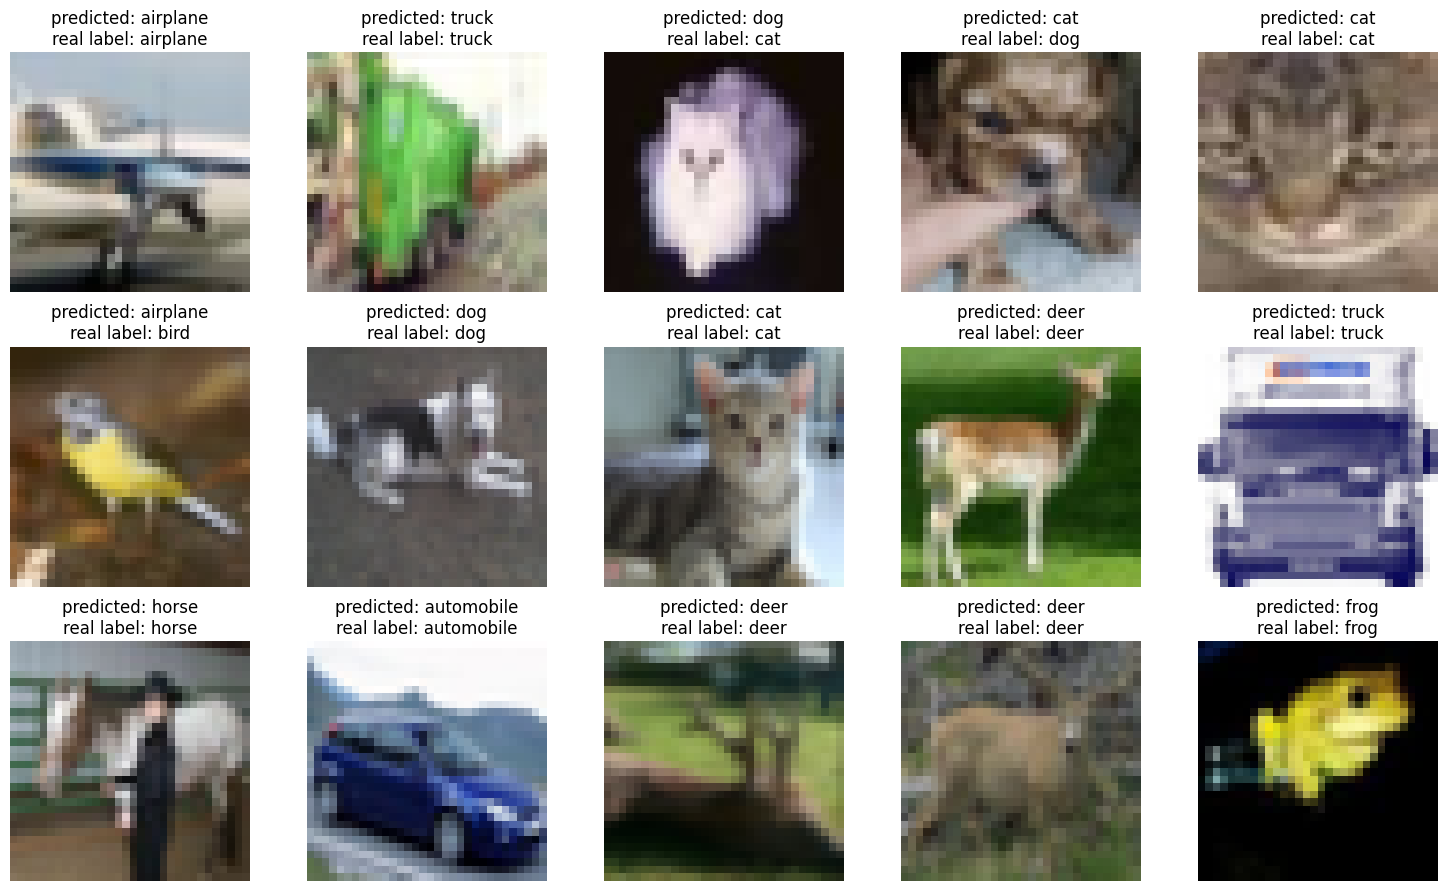

In [13]:
visualize_predictions(model)

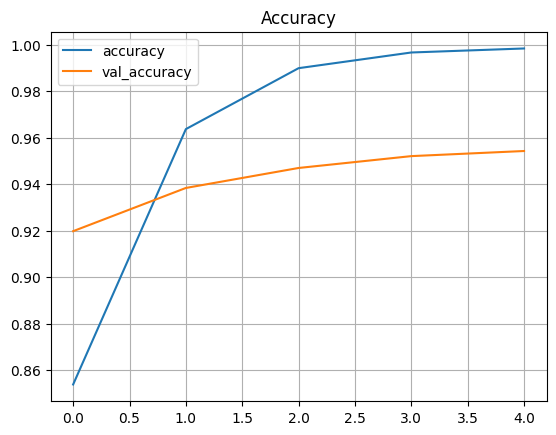

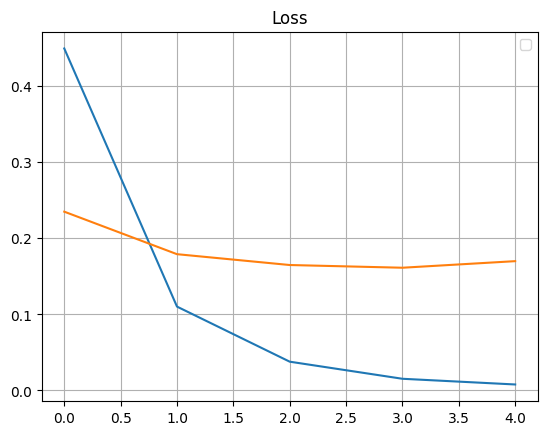

In [14]:
history_plot(history)

313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 82ms/step
Клас 0 (airplane): правильно класифіковано 952 з 1000 (95.20%)
Клас 1 (automobile): правильно класифіковано 968 з 1000 (96.80%)
Клас 2 (bird): правильно класифіковано 936 з 1000 (93.60%)
Клас 3 (cat): правильно класифіковано 897 з 1000 (89.70%)
Клас 4 (deer): правильно класифіковано 954 з 1000 (95.40%)
Клас 5 (dog): правильно класифіковано 916 з 1000 (91.60%)
Клас 6 (frog): правильно класифіковано 969 з 1000 (96.90%)
Клас 7 (horse): правильно класифіковано 956 з 1000 (95.60%)
Клас 8 (ship): правильно класифіковано 986 з 1000 (98.60%)
Клас 9 (truck): правильно класифіковано 961 з 1000 (96.10%)


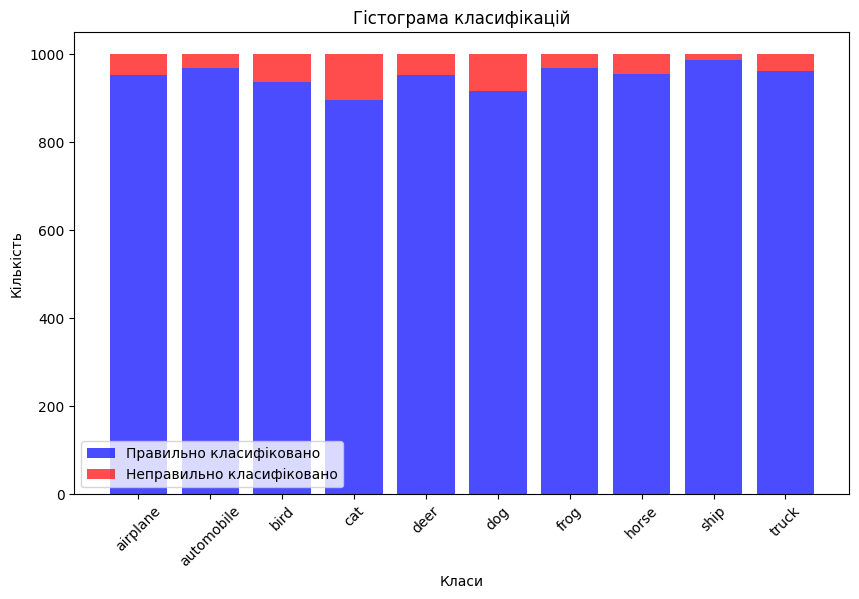

In [15]:
calculate_percent_right_mob(valid_X, y_test, model=model)